In [1]:
import inspect
import numpy as np
import pandas as pd
import csv
from scipy import stats
import os
import datetime
import sys
import time
import random
import json
import re
import pickle
from collections import Counter
import spacy
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

from surprise import similarities
from surprise import Dataset, Reader
from surprise import KNNWithMeans
from surprise.model_selection.split import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# !python -m spacy download en_core_web_lg

In [3]:
os.getcwd()

'/mnt/batch/tasks/shared/LS_root/mounts/clusters/avs-fallback-comp1/code/Users/asun/Whiskeys/Recommenders'

<br>

In [4]:
'''
https://realpython.com/build-recommendation-engine-collaborative-filtering/
https://surprise.readthedocs.io/en/stable/trainset.html 
https://nbviewer.org/github/NicolasHug/Surprise/blob/master/examples/notebooks/KNNBasic_analysis.ipynb 
https://uu.diva-portal.org/smash/get/diva2:1214390/FULLTEXT01.pdf 
https://machinelearningmastery.com/recommender-systems-resources/ 
https://towardsdatascience.com/introduction-to-recommender-systems-1-971bd274f421 
https://eugeneyan.com/writing/serendipity-and-accuracy-in-recommender-systems/

'''

'\nhttps://realpython.com/build-recommendation-engine-collaborative-filtering/\nhttps://surprise.readthedocs.io/en/stable/trainset.html \nhttps://nbviewer.org/github/NicolasHug/Surprise/blob/master/examples/notebooks/KNNBasic_analysis.ipynb \nhttps://uu.diva-portal.org/smash/get/diva2:1214390/FULLTEXT01.pdf \nhttps://machinelearningmastery.com/recommender-systems-resources/ \nhttps://towardsdatascience.com/introduction-to-recommender-systems-1-971bd274f421 \nhttps://eugeneyan.com/writing/serendipity-and-accuracy-in-recommender-systems/\n\n'

## READ FILE AND INITIAL EXPLORE

In [86]:
file_dir = '../Data_Files/' 

df_revs_rec = pd.read_csv(file_dir + 'whisk_reviews_recommender.csv')
print(f'Whiskey reviews dimension is {df_revs_rec.shape}')

df_revs_rec.sample(10)

Whiskey reviews dimension is (110610, 6)


,reviewer_name,reviewer_date,alc_name,alc_type,latest_avg_rating,latest_rev_date
25970,Jakub_K,"Tasted January 31, 2021",LOCH LOMOND 12 YEAR,single_malt,3.00,2021-01-31
13775,Daniel-Emerson,"Tasted November 26, 2021",KIRKLAND 20 YEAR SPEYSIDE SINGLE MALT SHERRY C...,single_malt,3.75,2021-11-26
104506,therealianmccoy,"Tasted September 27, 2019",OLD FITZGERALD BOTTLED IN BOND 11 YEAR (SPRING...,bourbon,4.50,2019-09-27
100005,sderrick,"Tasted November 29, 2020",WOODINVILLE STRAIGHT BOURBON,bourbon,3.50,2020-11-29
82370,jeffzep,"Tasted November 6, 2021",OLD FORESTER BIRTHDAY BOURBON 2021,bourbon,4.25,2021-11-06
61414,arcarey,"Tasted September 25, 2020",REDBREAST 27 YEAR,ireland_whiskey,5.00,2020-09-25
101131,skibeast,"Tasted July 5, 2020",EVAN WILLIAMS SINGLE BARREL VINTAGE 2012,bourbon,3.25,2020-07-05
2767,Andrew-Simpson,"Tasted May 4, 2018",GLEN SCOTIA VICTORIANA,single_malt,5.00,2018-05-04
85822,keda,"Tasted December 8, 2016",FILIBUSTER BOURBON,bourbon,4.00,2016-12-08
1591,Aged-One,"Tasted August 14, 2021",BLUE SPOT 7 YEAR CASK STRENGTH SINGLE POT STILL,ireland_whiskey,4.25,2021-08-14


### HOW SPARSE IS OUR MATRIX?

In [87]:
full_rows = len(set(df_revs_rec['alc_name']))*len(set(df_revs_rec['reviewer_name']))
act_rows = len(df_revs_rec)

print('If every reviewer reviewed every alcohol, ...' )
print(f'We would see {full_rows} rows of data')

print(f'\nActual rows of data is {act_rows}')
print(f'Our matrix is therefore {np.round(100 - 100*act_rows/full_rows, 3)}% sparse')

If every reviewer reviewed every alcohol, ...
We would see 80068648 rows of data

Actual rows of data is 110610
Our matrix is therefore 99.862% sparse


### NUMBER OF REVIEWS DONE BY USERS

In [7]:
# ZIPF
num_reviewers = len(set(df_revs_rec['reviewer_name']))
print(f'We have {num_reviewers} unique reviewers')

user_review_ct = df_revs_rec.groupby(['reviewer_name']).size().reset_index(name = 'ct_reviews')
reviewers_1_rev = len(user_review_ct.loc[user_review_ct['ct_reviews'] == 1,:])
print(f'{reviewers_1_rev} reviewers reviewed only 1 whiskey.')


user_review_ct.sort_values('ct_reviews', ascending = False)

We have 25729 unique reviewers
13135 reviewers reviewed only 1 whiskey.


,reviewer_name,ct_reviews
6890,Jose-Massu-Espinel,486
11644,Soba45,407
9698,PBMichiganWolverine,404
25469,worldwhiskies95,363
2930,ContemplativeFox,345
...,...,...
14665,benwright,1
14666,beow222,1
4800,Garth-Garrels,1
14669,beradfess,1


Text(0, 0.5, 'Count')

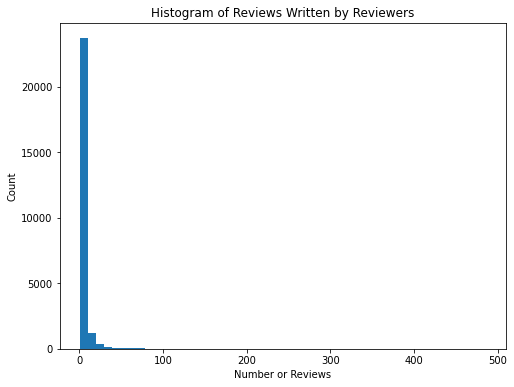

In [88]:
plt.figure(figsize=(8, 6))
plt.hist(user_review_ct['ct_reviews'], bins=50)
plt.title('Histogram of Reviews Written by Reviewers')
plt.xlabel('Number or Reviews')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

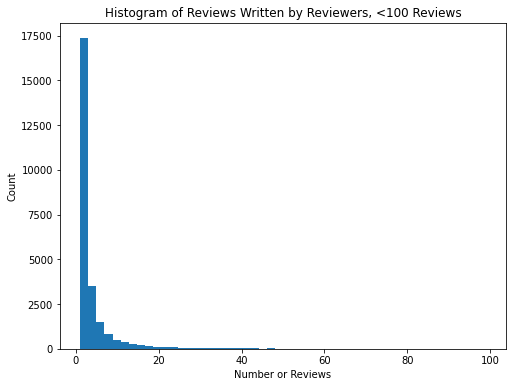

In [89]:
# 70% of reviewers write <5 reviews

plt.figure(figsize=(8, 6))
plt.hist(user_review_ct['ct_reviews'][user_review_ct['ct_reviews'] <= 100], bins=50)
plt.title('Histogram of Reviews Written by Reviewers, <100 Reviews')
plt.xlabel('Number or Reviews')
plt.ylabel('Count')

### HOW SPARSE IS MATRIX IF WE REMOVE REVIEWERS WITH TOO FEW REVIEWS?

In [90]:
df_revs_rec['rev_ct'] = 1
df_revs_rec['rev_ct'] = df_revs_rec.groupby('reviewer_name')['rev_ct'].transform(sum)
df_revs_rec = df_revs_rec.loc[df_revs_rec['rev_ct'] >= 3] # REMOVE REVIEWERS <=2 WHISKEYS

print(f"Proportion of Reviewers Remaining: {np.round(len(set(df_revs_rec['reviewer_name']))/num_reviewers, 3)}")

print(f'New whiskey reviews dimension is {df_revs_rec.shape}')

Proportion of Reviewers Remaining: 0.326
New whiskey reviews dimension is (89043, 7)


In [91]:
full_rows = len(set(df_revs_rec['alc_name']))*len(set(df_revs_rec['reviewer_name']))
act_rows = len(df_revs_rec)

print('If every reviewer reviewed every alcohol, ...' )
print(f'We would now see {full_rows} rows of data')

print(f'\nActual rows of data is {act_rows}')
print(f'Our new matrix is {np.round(100 - 100*act_rows/full_rows, 3)}% sparse')

If every reviewer reviewed every alcohol, ...
We would now see 26072336 rows of data

Actual rows of data is 89043
Our new matrix is 99.658% sparse


In [12]:
'''
One important thing to keep in mind is that in an approach based purely on collaborative filtering, 
the similarity is not calculated using factors like the age of users, genre of the movie, or any other data about users or items. 
It is calculated only on the basis of the rating (explicit or implicit) a user gives to an item. 
For example, two users can be considered similar if they give the same ratings to ten movies despite there being a big difference in their age.
'''

'\nOne important thing to keep in mind is that in an approach based purely on collaborative filtering, \nthe similarity is not calculated using factors like the age of users, genre of the movie, or any other data about users or items. \nIt is calculated only on the basis of the rating (explicit or implicit) a user gives to an item. \nFor example, two users can be considered similar if they give the same ratings to ten movies despite there being a big difference in their age.\n'

In [13]:
# WRITE A TOP 10 TYPE OF THING
# Serendipity and novelty --> specific concepts in recommender world
# Would you discover this item on your own, or is it only through us recommending it to you? 
# A measure of serendipity --> like how popular is it? 
# Find not-so-popular distillers, not-so-popular whiskeys, a DIFFERENT whiskey from the alc_type
# Inverse Zipf dist. --> boosting things low on tail for recommending
# Slope1 collaborative filtering --> it's in Surprise

In [14]:
# How do you determine which users or items are similar to one another?
# Given that you know which users are similar, how do you determine the rating that a user would give to an item based on the ratings of similar users?
# How do you measure the accuracy of the ratings you calculate?

## COLLABORATIVE FILTERING SETUP AND ANALYSIS

In [15]:
# PACKAGE CALLED SURPRISE
reader = Reader(rating_scale=(0, 5))

# Loads Pandas dataframe
ds_revs_rec = Dataset.load_from_df(df_revs_rec[["reviewer_name", "alc_name", "latest_avg_rating"]], reader)
print(type(ds_revs_rec))

# SET THE RANDOM SEED FOR REPRODUCIBILITY
np.random.seed(776926)

# BREAK OUT INTO TRAINING, TEST
trainset, testset = train_test_split(ds_revs_rec, test_size=0.2)
print(type(trainset))
print(type(testset))

<class 'surprise.dataset.DatasetAutoFolds'>
<class 'surprise.trainset.Trainset'>
<class 'list'>


### THREE KEY COMPONENTS -- USER (UID), ITEM (IID), RATING

In [92]:
ls_uid = [elem[0] for elem in ds_revs_rec.raw_ratings]
ls_iid = [elem[1] for elem in ds_revs_rec.raw_ratings]
ls_rating = [elem[2] for elem in ds_revs_rec.raw_ratings]

In [93]:
len(trainset.build_testset()) # TO GET THE TRAINSET, YOU CAN USE BUILD_TESTSET TO GET THE RATINGS DF

71234

In [94]:
trainset_df = trainset.build_testset()
trainset_df = {'uid': [x[0] for x in trainset_df], 'iid': [x[1] for x in trainset_df], 'act': [x[2] for x in trainset_df]}
trainset_df = pd.DataFrame(trainset_df)
trainset_df.sample(5)

,uid,iid,act
19858,webfoot,WILD TURKEY RYE 101,4.0
11263,Rosencrantz,ARDBEG BLAAACK (2020 COMMITTEE RELEASE),4.5
68634,Tony-Scotch,TOMINTOUL PEATY TANG,1.0
69818,Rob-Zatulsky,GLENMORANGIE QUINTA RUBAN PORT CASK FINISH 14 ...,4.0
50854,Sue-Schade,LONGMORN 16 YEAR,3.0


<br>

## COLLABORATIVE FILTERING WITH KNN, USER-BASED 

In [95]:
# NOTE -- THE BELOW ARE ALL HYPERPARAMETERS WE CAN TUNE 

KNN_NAME = 'cosine' # only takes common item ratings when calculating similarity -- i.e. two reviewers rated the same alcohol
KNN_MIN_SUP = 3 # minimum number of common items needed between users to consider them for similarity. For the item-based approach, this corresponds to the minimum number of common users for two items.
KNN_USER_TF = True # Item-based is more accurate? User-based seems more intuitive to understand
KNN_MAX_N = 10

In [96]:
# Use user-based cosine similarity
# Build model with options
sim_options = {
    "name": KNN_NAME,
    "min_support": KNN_MIN_SUP, 
    "user_based": KNN_USER_TF,  
    
}

algo = KNNWithMeans(sim_options=sim_options, k = KNN_MAX_N)

In [97]:
# FIT THE COLLAB FILTER ON THE TRAINING SET
fitted_algo = algo.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


### SANITY CHECK THE SIMILARITY MATRIX CALCULATION

In [98]:
sim_mtx = fitted_algo.compute_similarities()

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [99]:
# TWO BLOKES, Mchav and brockrexius
id_Mchav = np.where(trainset_df['uid'].drop_duplicates() == 'Mchav')[0][0]
id_brockrexius = np.where(trainset_df['uid'].drop_duplicates() == 'brockrexius')[0][0]

In [100]:
print('Shared ratings/reviews by the two reviewers')
sim_mtx_example = trainset_df.loc[np.isin(trainset_df['uid'], ['Mchav', 'brockrexius']), :].\
    pivot(index = 'iid', columns = 'uid', values = 'act').reset_index()
sim_mtx_example.loc[(~np.isnan(sim_mtx_example['Mchav'])) & (~np.isnan(sim_mtx_example['brockrexius'])), : ]

Shared ratings/reviews by the two reviewers


uid,iid,Mchav,brockrexius
35,JEFFERSON'S OCEAN AGED AT SEA VOYAGE 3,2.00,3.75
36,JOHNNY DRUM PRIVATE STOCK BOURBON,3.00,3.75
39,KIRKLAND SMALL BATCH KENTUCKY BOURBON 7 YEAR,1.75,3.75
71,ST. GEORGE BALLER SINGLE MALT WHISKY,0.25,4.00
73,STRANAHAN'S DIAMOND PEAK (OLD RECIPE),2.50,3.75


In [101]:
# MATCHES UP WITH WHAT IS WRITTEN IN DOCUMENTATION --> https://surprise.readthedocs.io/en/stable/similarities.html
# you'll note that matrices may have very high cosine similarities
print('Our self-calculated similarity between the two users')
print(cosine_similarity(np.array([[2, 3, 1.75, 0.25, 2.5], [3.75, 3.75, 3.75, 4, 3.75]])))

Our self-calculated similarity between the two users
[[1.        0.8875967]
 [0.8875967 1.       ]]


In [102]:
print('Surprise-calculated similarity between the two users')
print(sim_mtx[id_Mchav, id_brockrexius])

Surprise-calculated similarity between the two users
0.8875966979239559


### GET PREDICTIONS ON OUR TEST SET BY OUR COLLABORATIVE FILTER

In [103]:
predictions = algo.fit(trainset).test(testset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [104]:
print(predictions[100])
print(predictions[2000])

user: GuiJrmo    item: METHOD AND MADNESS SINGLE POT STILL FINISHED IN CHESTNUT CASKS r_ui = 5.00   est = 3.50   {'actual_k': 0, 'was_impossible': False}
user: K-franks1  item: REBEL YELL KENTUCKY STRAIGHT BOURBON 100 PROOF r_ui = 3.25   est = 3.09   {'actual_k': 1, 'was_impossible': False}


### LOOK AT THE PREDICTIONS AS A DATAFRAME

In [105]:
testset_df = {'uid': [x[0] for x in predictions], 'iid': [x[1] for x in predictions], 
              'act': [x[2] for x in predictions], 'est': [x[3] for x in predictions], 
              'impossible': [x[4]['was_impossible'] for x in predictions]}
testset_df = pd.DataFrame(testset_df)
testset_df.head()

actual_ks = []
for idx in range(len(testset_df)):
    if testset_df['impossible'][idx] == False:
        actual_ks.append(predictions[idx][4]['actual_k'])
    else:
        actual_ks.append(0)

testset_df['actual_k'] = actual_ks

testset_df.head()

,uid,iid,act,est,impossible,actual_k
0,Jacob-Hales,1792 BOTTLED IN BOND BOURBON,3.50,3.417968,False,10
1,Austin-Foster,GLEN GRANT 10 YEAR,4.00,4.000000,False,0
2,Dustin-Fisher,ROCK HILL FARMS BOURBON,4.00,4.505125,False,6
3,Soba45,HIGHLAND PARK 18 YEAR,3.75,4.179425,False,10
4,alafanlaman,WILLETT STRAIGHT RYE 4 YEAR,4.50,3.538462,False,0


### BACK-ENGINEER COLLABORATIVE FILTERING ESTIMATE RATING ON THE BACK END

In [106]:
testset_df.loc[testset_df['actual_k'] == 2].head(2)

,uid,iid,act,est,impossible,actual_k
17,magicalpoet,WOODFORD RESERVE DOUBLE DOUBLE OAKED (WINTER 2...,4.75,2.512613,False,2
20,Jason-Hugg,BULLEIT BOURBON SINGLE BARREL,4.25,3.918862,False,2


In [109]:
# OTHER IIDS REVIEWED BY THE UID OF INTEREST
other_whisks = trainset_df.loc[trainset_df['uid'] == 'Jason-Hugg']
other_whisks = other_whisks['iid']
print(other_whisks[0:10])
print('\n')

# OTHER UIDS WHO REVIEWED THE IID OF INTEREST
other_users = trainset_df.loc[trainset_df['iid'] == "BULLEIT BOURBON SINGLE BARREL"]
other_users = other_users['uid']
print(other_users[0:5])

38239            BOOKER'S BOURBON BATCH 2017-04 SIP AWHILE
38240    WILD TURKEY KENTUCKY SPIRIT SINGLE BARREL BOURBON
38241                         SIX & TWENTY 5 GRAIN BOURBON
38242        STONEHAMMER KENTUCKY STRAIGHT BOURBON WHISKEY
38243           AGITATOR KENTUCKY STRAIGHT BOURBON WHISKEY
38244                        KNOB CREEK TWICE BARRELED RYE
38245                             AMERICAN BARRELS BOURBON
38246                                    TWO STARS BOURBON
38247                      EAGLE RARE SINGLE BARREL SELECT
38248                    WOLCOTT KENTUCKY STRAIGHT BOURBON
Name: iid, dtype: object


2135       doublev
2507       canes76
3566    brbnjunkie
3704    BlimpsGo90
5738         Zslug
Name: uid, dtype: object


In [108]:
# VALID REVIEWERS MUST HAVE >= 3 OTHER SHARED WHISKEY REVIEWS WITH OUR REVIEWER OF INTEREST
df_whisk_user = trainset_df.loc[(np.isin(trainset_df['iid'], other_whisks)) & (np.isin(trainset_df['uid'], other_users))]
df_whisk_user['ct_similar_rev'] = df_whisk_user.groupby('uid')['iid'].transform(lambda x: sum(~x.isnull()))
df_whisk_user = df_whisk_user.loc[df_whisk_user['ct_similar_rev'] >= KNN_MIN_SUP]
df_whisk_user

/tmp/ipykernel_12049/2956545113.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_whisk_user['ct_similar_rev'] = df_whisk_user.groupby('uid')['iid'].transform(lambda x: sum(~x.isnull()))


,uid,iid,act,ct_similar_rev
3593,BlimpsGo90,BOOKER'S BOURBON BATCH 2017-04 SIP AWHILE,4.50,3
3599,BlimpsGo90,WILD TURKEY KENTUCKY SPIRIT SINGLE BARREL BOURBON,3.75,3
3654,BlimpsGo90,THE MACALLAN DOUBLE CASK 12 YEAR,3.25,3
17720,Sonic8222,WILD TURKEY KENTUCKY SPIRIT SINGLE BARREL BOURBON,4.00,3
17767,Sonic8222,KNOB CREEK TWICE BARRELED RYE,3.75,3
17778,Sonic8222,BOOKER'S BOURBON BATCH 2017-04 SIP AWHILE,4.00,3


In [110]:
# BACK-ENGINEER THE FORMULA GIVEN IN DOCUMENTATION 
# Link -- https://surprise.readthedocs.io/en/stable/knn_inspired.html

id_uid = np.where(trainset_df['uid'].drop_duplicates() == 'Jason-Hugg')[0][0]
id_1 = np.where(trainset_df['uid'].drop_duplicates() == 'BlimpsGo90')[0][0]
id_2 = np.where(trainset_df['uid'].drop_duplicates() == 'Sonic8222')[0][0]

print('Similarity with BlimpsGo90: ', sim_mtx[id_uid, id_1])
print('Similarity with Sonic8222: ', sim_mtx[id_uid, id_2])

Similarity with BlimpsGo90:  0.9993157928988735
Similarity with Sonic8222:  0.9966657558819869


In [111]:
u_mu = np.mean(trainset_df.loc[trainset_df['uid'] == 'Jason-Hugg', 'act'])
u1_mu = np.mean(trainset_df.loc[trainset_df['uid'] == 'BlimpsGo90', 'act'])
u1_id = float(trainset_df.loc[(trainset_df['uid'] == 'BlimpsGo90') & 
                        (trainset_df['iid'] == 'BULLEIT BOURBON SINGLE BARREL'), 'act'])
u2_mu = np.mean(trainset_df.loc[trainset_df['uid'] == 'Sonic8222', 'act'])
u2_id = float(trainset_df.loc[(trainset_df['uid'] == 'Sonic8222') & 
                        (trainset_df['iid'] == 'BULLEIT BOURBON SINGLE BARREL'), 'act'])

u_id_est = u_mu + (sim_mtx[id_uid, id_1]*(u1_id - u1_mu) + sim_mtx[id_uid, id_2]*(u2_id - u2_mu))/(sim_mtx[id_uid, id_1] + sim_mtx[id_uid, id_2])

print(f'Back-Engineered Estimate of Whiskey Prediction -- {np.round(u_id_est, 6)}')

testset_df.loc[testset_df['actual_k'] == 2].head(2)

Back-Engineered Estimate of Whiskey Prediction -- 3.918862


,uid,iid,act,est,impossible,actual_k
17,magicalpoet,WOODFORD RESERVE DOUBLE DOUBLE OAKED (WINTER 2...,4.75,2.512613,False,2
20,Jason-Hugg,BULLEIT BOURBON SINGLE BARREL,4.25,3.918862,False,2


### WHAT ARE IMPOSSIBLE PREDICTIONS?

Either the iid or the uid does not exist in the training set, so any matching simply cannot take place

In [112]:
print(f"Best the filter can do is assign the average of {np.round(np.mean(trainset_df['act']), 4)}")

testset_df.loc[testset_df['impossible'] == True].tail(10)

Best the filter can do is assign the average of 3.7438


,uid,iid,act,est,impossible,actual_k
15036,Jordan-Steele,FOUR ROSES YELLOW LABEL BOURBON,2.75,3.743799,True,0
15067,MarkZ,OLD FORESTER STATESMAN,3.75,3.743799,True,0
15079,KillaB,WITHERSPOON'S TEXAS STRAIGHT BOURBON WHISKEY,2.75,3.743799,True,0
15402,MarkZ,OBAN LITTLE BAY,3.50,3.743799,True,0
15643,KillaB,STRANAHAN'S COLORADO WHISKEY,3.50,3.743799,True,0
16000,tkhanes,KERN IRISH WHISKEY,1.50,3.743799,True,0
16709,frogger416,FEW RYE,3.00,3.743799,True,0
16811,WhiskeyWizards,KILCHOMAN SANAIG 2016,3.75,3.743799,True,0
17475,wimija,GLENFARCLAS 10 YEAR,3.00,3.743799,True,0
17653,viharsheth,NIKKA BLACK SPECIAL,4.00,3.743799,True,0


In [113]:
# CONFIRM THE IMPOSSIBLES IN THE TRAINING SET
print(trainset_df.loc[trainset_df['iid'] == 'KERN IRISH WHISKEY'])
print(trainset_df.loc[trainset_df['uid'] == 'frogger416'])

Empty DataFrame
Columns: [uid, iid, act]
Index: []
Empty DataFrame
Columns: [uid, iid, act]
Index: []


### WHAT ARE PREDICTIONS THAT ARE POSSIBLE BUT HAVE ACTUAL_K = 0?

The reviewer of interest and alcohol of interest are found in the training set... <br>
But none of the related reviewer have enough other alcohol ratings in common with another user.

In [37]:
testset_df.loc[testset_df['actual_k'] == 0].head(10)

,uid,iid,act,est,impossible,actual_k
1,Austin-Foster,GLEN GRANT 10 YEAR,4.00,4.000000,False,0
4,alafanlaman,WILLETT STRAIGHT RYE 4 YEAR,4.50,3.538462,False,0
5,foodnbeer,"VAN WINKLE SPECIAL RESERVE LOT ""B"" 12 YEAR",3.75,3.500000,False,0
8,KianF,GLENMORANGIE SIGNET,3.75,3.450000,False,0
10,badspellersuntie,WEST CORK BOURBON CASK,4.00,3.281250,False,0
14,cplong,TALISKER PORT RUIGHE,3.75,4.375000,False,0
15,ScottinJapan,JAMESON CASKMATES STOUT EDITION,4.00,4.250000,False,0
18,Martel47,TALISKER 18 YEAR,4.50,4.750000,False,0
26,richardslenders,GLENFIDDICH AGE OF DISCOVERY MADEIRA CASK 19 YEAR,4.75,3.812500,False,0
30,binyinbin,CAOL ILA 15 YEAR 2000 (2016 SPECIAL RELEASE),5.00,3.666667,False,0


In [114]:
alc_by_uid = np.array(trainset_df.loc[trainset_df['uid'] =="badspellersuntie",'iid'])
print('\n Other Alcs Rated by Reviewer of Interest: \n', alc_by_uid)

user_by_iid = np.array(trainset_df.loc[trainset_df['iid'] =="WEST CORK BOURBON CASK",'uid'])
print('\n Other Reviewers that Reviewed the Alc of Interest: \n', user_by_iid)

df_commons = trainset_df.loc[(np.isin(trainset_df['uid'],user_by_iid)) & (np.isin(trainset_df['iid'],alc_by_uid)),: ]
print('\n Related Alcohols Reviewed by Related Reviewers: \n', df_commons)

# NOTE -- this 'ct' value will always be below the KNN_MIN_SUP param
df_commons.groupby('uid').size().reset_index(name = 'ct_common_alc') 


 Other Alcs Rated by Reviewer of Interest: 
 ['WHISTLEPIG 6 YEAR PIGGYBACK RYE'
 'TULLAMORE D.E.W. CIDER CASK LIMITED EDITION'
 'THE GLENLIVET CARIBBEAN RESERVE'
 'AMRUT FUSION INDIAN SINGLE MALT WHISKY' 'MAD RIVER RYE'
 'BALCONES TEXAS RYE 100 PROOF'
 'THE WALKING DEAD KENTUCKY STRAIGHT BOURBON' 'DANCING GOAT LIMOUSIN RYE']

 Other Reviewers that Reviewed the Alc of Interest: 
 ['nmoon' 'StefdeM' 'VanillaMike' 'Pat-Sorohan' 'Morgan_Freeman' 'LeonQ'
 'bpoirier404' 'btp3']

 Related Alcohols Reviewed by Related Reviewers: 
                uid                                          iid   act
15341        nmoon                                MAD RIVER RYE  2.00
39382  Pat-Sorohan  TULLAMORE D.E.W. CIDER CASK LIMITED EDITION  4.25


,uid,ct_common_alc
0,Pat-Sorohan,1
1,nmoon,1


In [115]:
# Surprise Package sets estimate for actual_k = 0 records to be AVERAGE RATING of the UID (for USER-BASED Collab Filter)
# THIS IS NOT HARD AND FAST RULE

print('Estimates for the user rating where the alcohol rated has actual_k = 0: \n')
print(testset_df.loc[(testset_df['uid'] =="badspellersuntie") & (testset_df['actual_k'] ==0),:])

print('\nAverage of all ratings by the user in the training set: ')
print(np.mean(trainset_df.loc[trainset_df['uid'] == "badspellersuntie"]))

trainset_df.loc[trainset_df['uid'] == "badspellersuntie"]

Estimates for the user rating where the alcohol rated has actual_k = 0: 

                   uid                                               iid  act  \
10    badspellersuntie                            WEST CORK BOURBON CASK  4.0   
4435  badspellersuntie                  BREUCKELEN 77 RYE & CORN WHISKEY  3.0   
9493  badspellersuntie  CATOCTIN CREEK RABBLE ROUSER BOTTLED IN BOND RYE  3.0   

          est  impossible  actual_k  
10    3.28125       False         0  
4435  3.28125       False         0  
9493  3.28125       False         0  

Average of all ratings by the user in the training set: 
act    3.28125
dtype: float64


,uid,iid,act
46377,badspellersuntie,WHISTLEPIG 6 YEAR PIGGYBACK RYE,3.00
46378,badspellersuntie,TULLAMORE D.E.W. CIDER CASK LIMITED EDITION,4.50
46379,badspellersuntie,THE GLENLIVET CARIBBEAN RESERVE,3.50
46380,badspellersuntie,AMRUT FUSION INDIAN SINGLE MALT WHISKY,5.00
46381,badspellersuntie,MAD RIVER RYE,2.25
46382,badspellersuntie,BALCONES TEXAS RYE 100 PROOF,1.75
46383,badspellersuntie,THE WALKING DEAD KENTUCKY STRAIGHT BOURBON,2.50
46384,badspellersuntie,DANCING GOAT LIMOUSIN RYE,3.75


### HOW MANY ALCOHOL REVIEWS HAVE 0 NNs?

In [40]:
# there are quite a few where actual_k == 0 --> 4k/15 total ~ 30%
print('Proportion of alcohol reviews in test set with exactly 0 Nearest Neighbors to "collaborate with": ')
print(np.round(testset_df.loc[testset_df['actual_k'] == 0, :].shape[0]/len(testset_df), 3))

# this is an example of a long-tailed problem --> Zipf distribution
print('Proportion of alcohol reviews in test set with < 3 Nearest Neighbors to "collaborate with": ')
print(np.round(testset_df.loc[testset_df['actual_k'] < 3, :].shape[0]/len(testset_df), 3))

testset_df.loc[testset_df['actual_k'] < 3, :].sample(5)

Proportion of alcohol reviews in test set with exactly 0 Nearest Neighbors to "collaborate with": 
0.383
Proportion of alcohol reviews in test set with < 3 Nearest Neighbors to "collaborate with": 
0.563


,uid,iid,act,est,impossible,actual_k
16124,mveronese08,KNOB CREEK TWICE BARRELED RYE,3.5,3.187500,False,0
8410,Sturox,THE BALVENIE TRIPLE CASK 12 YEAR,3.0,3.258894,False,2
15962,tsunaminoai,HIGH WEST AMERICAN PRAIRIE BOURBON,4.0,3.125000,False,0
3301,awieckert,ARDBEG DRUM (2019 COMMITTEE RELEASE),4.0,3.416667,False,0
10573,beeberbmx,TALISKER DISTILLERS EDITION (2020 RELEASE),4.0,3.700000,False,0


In [41]:
iterator = trainset.all_ratings()
len(list(iterator)) # IS IS THE SAME SIZE AS TRAINSET

71234

<br>

## WHAT WE CAN DO WITH OUR COLLABORATIVE FILTER

### TAKE A LOOK AT BEST AND WORST PREDICTIONS

In [116]:
# lots of them the more accurate predictions have actual_k = 0
testset_df['abs_diff'] = np.abs(testset_df['act'] - testset_df['est'])
testset_df.sort_values('abs_diff').head(10)

,uid,iid,act,est,impossible,actual_k,abs_diff
17808,jdottie88,PINHOOK BOURBON COUNTRY CASK STRENGTH,3.25,3.25,False,0,0.0
10877,ericjackholland,GEORGE T. STAGG BOURBON (FALL 2018),4.50,4.50,False,0,0.0
905,alysania,BALLYHOO IRISH WHISKEY,4.00,4.00,False,0,0.0
10844,worldwhiskies95,BRUICHLADDICH BLACK ART 1994 07.1 EDITION 25 YEAR,5.00,5.00,False,3,0.0
10801,quickwing,PAPPY VAN WINKLE 23 YEAR,4.00,4.00,False,0,0.0
10730,DHSpeedy,BENRIACH SOLSTICE 2ND EDITION 17 YEAR,5.00,5.00,False,3,0.0
10681,andrekroe,HAZELBURN 13 YEAR OLOROSO CASK MATURED,5.00,5.00,False,1,0.0
10670,Assclown,J. HENRY & SONS 5 YEAR WISCONSIN STRAIGHT BOURBON,2.00,2.00,False,0,0.0
10659,worldwhiskies95,PAUL JOHN CHRISTMAS EDITION 2020,5.00,5.00,False,3,0.0
10625,svobodax,TAKETSURU PURE MALT (DISCONTINUED),4.25,4.25,False,0,0.0


In [118]:
# filter on records where the actual_k > 1?
testset_df.sort_values('abs_diff').loc[testset_df['actual_k'] > 1].head(10)

,uid,iid,act,est,impossible,actual_k,abs_diff
10844,worldwhiskies95,BRUICHLADDICH BLACK ART 1994 07.1 EDITION 25 YEAR,5.0,5.0,False,3,0.0
10730,DHSpeedy,BENRIACH SOLSTICE 2ND EDITION 17 YEAR,5.0,5.0,False,3,0.0
10659,worldwhiskies95,PAUL JOHN CHRISTMAS EDITION 2020,5.0,5.0,False,3,0.0
11465,worldwhiskies95,DALMORE 18 YEAR,5.0,5.0,False,10,0.0
11230,GMofMiami,"BOOKER'S BOURBON BATCH 2015-01 ""BIG MAN, SMALL...",5.0,5.0,False,3,0.0
9939,cthach704,JOHN J BOWMAN SINGLE BARREL BOURBON,5.0,5.0,False,3,0.0
9170,worldwhiskies95,TAKETSURU PURE MALT 12 YEAR,5.0,5.0,False,10,0.0
9317,worldwhiskies95,HIGHLAND PARK THE DARK 17 YEAR,5.0,5.0,False,10,0.0
9824,BillSlone07,GARRISON BROTHERS COWBOY BOURBON (2019 RELEASE),5.0,5.0,False,4,0.0
9483,nomoreswill1,PAPPY VAN WINKLE 23 YEAR,5.0,5.0,False,6,0.0


In [119]:
testset_df.sort_values('abs_diff').tail(20)

,uid,iid,act,est,impossible,actual_k,abs_diff
17123,sdmoflsmo,BARRELL ARMIDA,0.50,4.048856,False,10,3.548856
7433,brbnhntr,FEW BOURBON,0.25,3.850000,False,0,3.600000
11763,brbnhntr,IRON SMOKE STRAIGHT BOURBON,0.25,3.850000,False,0,3.600000
10980,justinsayen,GLENGLASSAUGH REVIVAL,0.75,4.375000,False,0,3.625000
13332,mikem23,GARRISON BROTHERS TEXAS STRAIGHT BOURBON,1.00,4.750000,False,0,3.750000
9888,bdumonte,FOUR ROSES SINGLE BARREL BOURBON,0.75,4.500000,False,0,3.750000
16105,rmakows,OLD GRAND-DAD 114 BOURBON,1.00,4.750000,False,0,3.750000
17394,apto11,FEW SINGLE MALT WHISKY,0.25,4.000000,False,0,3.750000
13534,mikem23,GARRISON BROTHERS TEXAS STRAIGHT BOURBON WHISK...,1.00,4.750000,False,0,3.750000
14436,trentoniousmaximus,HOCHSTADTER'S SLOW & LOW ROCK & RYE (84 PROOF),0.25,4.011905,False,0,3.761905


In [120]:
# EXAMINE SOME OF THE WORST ESTIMATES, e.g. "TALISKER 18 YEAR", "LAPHROAIG 18 YEAR"
# Martin-Gallagher and Duscandy seem like obnoxious assholes

print(np.mean(trainset_df.loc[trainset_df['iid'] == 'BOWMORE 18 YEAR', 'act']))
trainset_df.loc[trainset_df['iid'] == 'BOWMORE 18 YEAR'].sample(10)

4.2368421052631575


,uid,iid,act
53650,Littlegebtlem4n,BOWMORE 18 YEAR,4.00
37363,tjunkens,BOWMORE 18 YEAR,4.75
25655,AlexNaud,BOWMORE 18 YEAR,4.00
6819,petermania,BOWMORE 18 YEAR,4.00
22486,welchez,BOWMORE 18 YEAR,5.00
1282,Jose-Massu-Espinel,BOWMORE 18 YEAR,4.25
11059,PBMichiganWolverine,BOWMORE 18 YEAR,5.00
36265,Rksnab,BOWMORE 18 YEAR,4.00
8728,Camardicus,BOWMORE 18 YEAR,5.00
56493,Black-Eyed-Dog,BOWMORE 18 YEAR,3.50


### IDENTIFY CONTRARIANS -- (READ: OBNOXIOUS JERKS, POTENTIALLY)

What is good on average is bad for them, and what is bad on average is good for them. <br>
They're "different / elevated".

In [121]:
trainset_df.loc[trainset_df['uid'] == 'MooreScotch21'].sample(10)

,uid,iid,act
31701,MooreScotch21,HIGHLAND PARK 18 YEAR VIKING PRIDE,4.0
31712,MooreScotch21,JAMESON 18 YEAR LIMITED RESERVE,4.0
31702,MooreScotch21,JAMESON 12 YEAR SPECIAL RESERVE,4.0
31710,MooreScotch21,THE MACALLAN CASK STRENGTH,5.0
31711,MooreScotch21,HIGHLAND PARK 25 YEAR,5.0
31705,MooreScotch21,THE MACALLAN FINE OAK 15 YEAR,4.0
31713,MooreScotch21,THE GLENLIVET NÀDURRA 16 YEAR,4.0
31709,MooreScotch21,JIM BEAM DISTILLER'S MASTERPIECE,4.5
31706,MooreScotch21,THE GLENROTHES 1994,3.0
31703,MooreScotch21,THE MACALLAN FINE OAK 17 YEAR,4.0


In [122]:
avg_alc_rating = np.mean(trainset_df['act'])

trainset_iids = trainset_df.groupby(['iid']).apply(lambda x: np.mean(x.act) - avg_alc_rating).reset_index(name = 'iid_diff') 
trainset_uids = trainset_df.groupby(['uid']).apply(lambda x: np.mean(x.act)).reset_index(name = 'uid_avg') 
trainset_iids.sample(10)
trainset_uids.sample(10)

,uid,uid_avg
1448,Fredrik-Jensen,3.416667
1767,Ivan-Mironov,3.416667
2986,Nyx,4.000000
164,Alex-LaBue,3.000000
2853,MrSpiffy,4.000000
5162,cpeters24,4.000000
3519,SecondHandTime,2.583333
4552,aroseashes,3.166667
7211,pete_smoke,4.250000
6535,korayko,3.250000


In [123]:
testset_jerk = testset_df.copy()
testset_jerk = testset_jerk.loc[testset_jerk['impossible'] == False].reset_index(drop = True)
testset_jerk = pd.merge(testset_jerk, trainset_iids, 'left', on = ['iid'])
testset_jerk = pd.merge(testset_jerk, trainset_uids, 'left', on = ['uid'])
testset_jerk['diff_rtg'] = (testset_jerk['act'] - testset_jerk['uid_avg']) - (testset_jerk['iid_diff'])
testset_jerk['ct_revs_test'] = testset_jerk.groupby(['uid'])['act'].transform(lambda x: sum(~np.isnan(x)))

testset_jerk.head()

,uid,iid,act,est,impossible,actual_k,abs_diff,iid_diff,uid_avg,diff_rtg,ct_revs_test
0,Jacob-Hales,1792 BOTTLED IN BOND BOURBON,3.50,3.417968,False,10,0.082032,-0.075320,3.640625,-0.065305,11.0
1,Austin-Foster,GLEN GRANT 10 YEAR,4.00,4.000000,False,0,0.000000,-0.672370,4.000000,0.672370,2.0
2,Dustin-Fisher,ROCK HILL FARMS BOURBON,4.00,4.505125,False,6,0.505125,0.414617,4.113636,-0.528254,1.0
3,Soba45,HIGHLAND PARK 18 YEAR,3.75,4.179425,False,10,0.429425,0.642313,3.667187,-0.559500,87.0
4,alafanlaman,WILLETT STRAIGHT RYE 4 YEAR,4.50,3.538462,False,0,0.961538,0.121586,3.538462,0.839952,6.0


In [124]:
testset_fin = testset_jerk \
    .groupby(['uid', 'impossible', 'ct_revs_test']) \
    .apply(lambda x: np.mean(x.diff_rtg)).reset_index(name = 'mean_diff').sort_values('mean_diff')

testset_fin = testset_fin.loc[testset_fin['ct_revs_test'] >= 2].head(20) # IF ONLY 1 REVIEW, MIGHT BE BIASED
testset_fin

,uid,impossible,ct_revs_test,mean_diff
4907,mikem23,False,2.0,-3.143739
3383,belligerentfarmer,False,2.0,-2.509999
3290,apto11,False,2.0,-2.444335
1363,Jahbulon_Assassin,False,2.0,-2.293490
4193,grantfisher34,False,2.0,-2.171125
3371,bdumonte,False,2.0,-2.047924
3797,dac975,False,2.0,-1.979516
807,Dazzabozza,False,2.0,-1.945867
2281,Phoebus,False,2.0,-1.814866
5752,trevorslade1,False,2.0,-1.798127


In [125]:
testset_jerk.loc[np.isin(testset_jerk['uid'], testset_fin['uid'][0:10]),:].sort_values(['uid'])

,uid,iid,act,est,impossible,actual_k,abs_diff,iid_diff,uid_avg,diff_rtg,ct_revs_test
13567,Dazzabozza,JIM BEAM DEVIL'S CUT,2.00,4.083333,False,0,2.083333,-0.721924,4.083333,-1.361410,2.0
958,Dazzabozza,JIM BEAM BONDED BOURBON,1.25,4.083333,False,0,2.833333,-0.303009,4.083333,-2.530324,2.0
17165,Jahbulon_Assassin,KAIYŌ JAPANESE MIZUNARA OAK,1.00,5.000000,False,0,4.000000,-0.269222,5.000000,-3.730778,2.0
9325,Jahbulon_Assassin,MAKER'S MARK PRIVATE SELECT BOURBON,4.50,5.000000,False,0,0.500000,0.356201,5.000000,-0.856201,2.0
11815,Phoebus,LAPHROAIG CAIRDEAS 200TH ANNIVERSARY EDITION,1.75,3.700000,False,0,1.950000,0.801656,3.700000,-2.751656,2.0
15414,Phoebus,THE GLENROTHES 1998,3.00,3.700000,False,0,0.700000,0.178076,3.700000,-0.878076,2.0
17320,apto11,FEW SINGLE MALT WHISKY,0.25,4.000000,False,0,3.750000,-0.735178,4.000000,-3.014822,2.0
17602,apto11,KUJIRA RYUKYU WHISKY 8 YEARS,2.00,4.000000,False,0,2.000000,-0.126152,4.000000,-1.873848,2.0
9389,bdumonte,ELIJAH CRAIG SMALL BATCH BOURBON,4.25,4.500000,False,0,0.250000,-0.148561,4.500000,-0.101439,2.0
9844,bdumonte,FOUR ROSES SINGLE BARREL BOURBON,0.75,4.500000,False,0,3.750000,0.244409,4.500000,-3.994409,2.0


### RECOMMEND NEW ALCOHOLS TO USERS

In [126]:
### FIRST, CONSIDER A RANDOM USER WITH MANY RATINGS UNDER THEIR POCKET
df_revs_reviewer = trainset_df.groupby(['uid']).\
    apply(lambda x: pd.Series({'rev_avg_rating': np.mean(x.act), 'ct_rev': x.shape[0]})).reset_index()

df_revs_reviewer = df_revs_reviewer.loc[df_revs_reviewer['ct_rev'] >= 15].reset_index(drop = True)
df_revs_reviewer.sample(10)

,uid,rev_avg_rating,ct_rev
943,spiritstradeer,3.532609,23.0
845,metalgenius,3.583333,33.0
61,Bigcisme,3.602941,17.0
366,Pat-Sorohan,4.142857,35.0
807,krandall85,3.404762,21.0
133,Dan_Giggy,3.848214,28.0
271,JoelyO,3.715909,22.0
770,jkannen,3.472222,18.0
519,WhiskyIvan,3.733333,30.0
990,tylerss20,3.777778,54.0


In [127]:
df_reviewer_sample = df_revs_reviewer.sample()
reviewer_name = np.array(df_reviewer_sample['uid'])[0]
df_reviewer_sample

,uid,rev_avg_rating,ct_rev
522,WhiskyWeekly,3.7125,40.0


In [128]:
trainset_df.loc[trainset_df['uid'] == reviewer_name].sample(10)

,uid,iid,act
43135,WhiskyWeekly,ANCNOC PEATHEART,3.75
43161,WhiskyWeekly,CRAIGELLACHIE 17 YEAR,3.00
43152,WhiskyWeekly,TOBERMORY 10 YEAR,3.75
43137,WhiskyWeekly,TALISKER PORT RUIGHE,4.00
43149,WhiskyWeekly,BOWMORE 15 YEAR,4.00
43160,WhiskyWeekly,CAOL ILA 18 YEAR,4.00
43151,WhiskyWeekly,BRUICHLADDICH BLACK ART 1990 06.1 EDITION 26 YEAR,4.50
43133,WhiskyWeekly,BALBLAIR 1999 2ND RELEASE,4.25
43154,WhiskyWeekly,OLD PULTENEY 17 YEAR,4.00
43131,WhiskyWeekly,TULLIBARDINE 228 BURGUNDY FINISH,3.75


### FIND POPULAR ALCOHOLS (THOSE WITH >= 20 REVIEWS?) THEY MIGHT LIKE

In [129]:
df_revs_alc = trainset_df.groupby(['iid']).\
    apply(lambda x: pd.Series({'alc_avg_rating': np.mean(x.act), 'ct_alc': x.shape[0]})).reset_index() # .size duplicates by # of columns
print(df_revs_alc['ct_alc'].describe())

count    3102.000000
mean       22.963894
std        27.167010
min         1.000000
25%         5.000000
50%        11.000000
75%        27.750000
max       119.000000
Name: ct_alc, dtype: float64


In [130]:
df_alc_popular = df_revs_alc.loc[df_revs_alc['ct_alc'] >= 20]
ls_alc_popular = list(df_alc_popular['iid'])
print(df_alc_popular.shape)

(1021, 3)


In [131]:
ls_user_preds = []
for idx in range(len(ls_alc_popular)):
    ls_user_preds.append(algo.predict(reviewer_name, ls_alc_popular[idx]))

In [132]:
userpreds_df = {'uid': [x[0] for x in ls_user_preds], 'iid': [x[1] for x in ls_user_preds], 
                'est': [x[3] for x in ls_user_preds], 'details': [x[4] for x in ls_user_preds]}
userpreds_df = pd.DataFrame(userpreds_df)

userpreds_df.sort_values('est', ascending = False).reset_index(drop = True).head(15)

,uid,iid,est,details
0,WhiskyWeekly,WILLIAM LARUE WELLER BOURBON (FALL 2017),5.000000,"{'actual_k': 2, 'was_impossible': False}"
1,WhiskyWeekly,WOODFORD RESERVE MASTER'S COLLECTION BATCH PRO...,5.000000,"{'actual_k': 1, 'was_impossible': False}"
2,WhiskyWeekly,"COLONEL E.H. TAYLOR, JR. SEASONED WOOD BOTTLED...",5.000000,"{'actual_k': 1, 'was_impossible': False}"
3,WhiskyWeekly,GEORGE T. STAGG BOURBON (FALL 2020),4.950781,"{'actual_k': 1, 'was_impossible': False}"
4,WhiskyWeekly,OLD FITZGERALD BOTTLED IN BOND 15 YEAR (FALL 2...,4.895051,"{'actual_k': 2, 'was_impossible': False}"
5,WhiskyWeekly,BELLE MEADE CASK STRENGTH RESERVE BOURBON,4.872826,"{'actual_k': 1, 'was_impossible': False}"
6,WhiskyWeekly,"BOOKER'S BOURBON BATCH 2021-02 ""TAGALONG BATCH""",4.872826,"{'actual_k': 1, 'was_impossible': False}"
7,WhiskyWeekly,WELLER FULL PROOF BOURBON,4.856439,"{'actual_k': 1, 'was_impossible': False}"
8,WhiskyWeekly,THE MACALLAN 25 YEAR SHERRY OAK CASK,4.841068,"{'actual_k': 5, 'was_impossible': False}"
9,WhiskyWeekly,BELLE MEADE CASK STRENGTH SINGLE BARREL BOURBO...,4.834122,"{'actual_k': 1, 'was_impossible': False}"


### FIND LESS POPULAR WHISKEYS (e.g. RATED >= 5 & < 10 TIMES) THEY MIGHT LIKE?

Other extensions include alcohols within a certain price range, etc.

In [133]:
df_alc_rare = df_revs_alc.loc[(df_revs_alc['ct_alc'] >= 5) & (df_revs_alc['ct_alc'] < 10)]
ls_alc_rare = list(df_alc_rare['iid'])
print(df_alc_rare.shape)

(838, 3)


In [134]:
ls_user_preds = []
for idx in range(len(ls_alc_rare)):
    ls_user_preds.append(algo.predict(reviewer_name, ls_alc_rare[idx]))

In [135]:
userpreds_df = {'uid': [x[0] for x in ls_user_preds], 'iid': [x[1] for x in ls_user_preds], 
                'est': [x[3] for x in ls_user_preds], 'details': [x[4] for x in ls_user_preds]}
userpreds_df = pd.DataFrame(userpreds_df)

userpreds_df.sort_values('est', ascending = False).reset_index(drop = True).head(10)

,uid,iid,est,details
0,WhiskyWeekly,HIGHLAND PARK 30 YEAR,5.000000,"{'actual_k': 1, 'was_impossible': False}"
1,WhiskyWeekly,LAGAVULIN 16 - WHITE HORSE DISTILLERS,5.000000,"{'actual_k': 1, 'was_impossible': False}"
2,WhiskyWeekly,HIGHLAND PARK ODIN,5.000000,"{'actual_k': 2, 'was_impossible': False}"
3,WhiskyWeekly,THE BALVENIE TUN 1509 BATCH 2,5.000000,"{'actual_k': 1, 'was_impossible': False}"
4,WhiskyWeekly,PORT ASKAIG 10 YEAR 10TH ANNIVERSARY,5.000000,"{'actual_k': 1, 'was_impossible': False}"
5,WhiskyWeekly,KING OF KENTUCKY 15 YEAR KENTUCKY STRAIGHT BOU...,5.000000,"{'actual_k': 1, 'was_impossible': False}"
6,WhiskyWeekly,PORT ELLEN 32 YEAR 1979 (2012 SPECIAL RELEASE),5.000000,"{'actual_k': 2, 'was_impossible': False}"
7,WhiskyWeekly,ARDBEG TWENTY SOMETHING 23 YEAR,5.000000,"{'actual_k': 4, 'was_impossible': False}"
8,WhiskyWeekly,YAMAZAKI 25 YEAR (DISCONTINUED),4.955556,"{'actual_k': 1, 'was_impossible': False}"
9,WhiskyWeekly,BARDSTOWN BOURBON CO. PHIFER PAVITT RESERVE FI...,4.913889,"{'actual_k': 1, 'was_impossible': False}"


### FIND SOME WHISKEYS FOR A REVIEWER WHO WANTS TO TRY SOMETHING DIFFERENT ("NOVELTY")

In [136]:
df_reviewer_sample = df_revs_reviewer.sample()
# df_reviewer_sample = df_revs_reviewer.loc[df_revs_reviewer['uid'] == 'ngolofane'] # OR 'Lyrical'

reviewer_name = np.array(df_reviewer_sample['uid'])[0]

df_reviewer_sample

,uid,rev_avg_rating,ct_rev
653,crouly,3.681818,33.0


In [137]:
df_reviewer = trainset_df.loc[trainset_df['uid'] == reviewer_name]
df_reviewer.sample(5)

,uid,iid,act
6023,crouly,THE BALVENIE TRIPLE CASK 12 YEAR,4.00
6044,crouly,LONGROW 18 YEAR,4.00
6028,crouly,HIGHLAND PARK 10 YEAR VIKING SCARS,3.75
6038,crouly,LEDAIG 18 YEAR,4.00
6040,crouly,AMRUT FUSION INDIAN SINGLE MALT WHISKY,3.75


In [138]:
# SOEMTHING TRIED = AT LEAST 2 OF THAT ALCOHOL TYPE
df_alc_tried = pd.merge(df_reviewer, df_revs_rec[['alc_name', 'alc_type']].drop_duplicates(), "left", \
    left_on = ['iid'], right_on = ['alc_name']).groupby(['uid', 'alc_type']).size().reset_index(name = 'ct_alc_type')
df_alc_tried = df_alc_tried.loc[df_alc_tried['ct_alc_type'] > 1]
df_alc_tried

,uid,alc_type,ct_alc_type
1,crouly,ireland_whiskey,4
3,crouly,other_whiskey,3
4,crouly,single_malt,18
5,crouly,single_malt_peated,6


In [139]:
# ANY ALC >= 5 REVIEWS
df_alc_all = df_revs_alc.loc[df_revs_alc['ct_alc'] >= 5]
ls_alc_all = list(df_alc_all['iid'])

In [140]:
ls_user_preds = []
for idx in range(len(ls_alc_all)):
    ls_user_preds.append(algo.predict(reviewer_name, ls_alc_all[idx]))

In [141]:
userpreds_df = {'uid': [x[0] for x in ls_user_preds], 'iid': [x[1] for x in ls_user_preds], 
                'est': [x[3] for x in ls_user_preds], 'details': [x[4] for x in ls_user_preds]}
userpreds_df = pd.DataFrame(userpreds_df)

# A DIFFERENT TYPE OF ALC
userpreds_df = pd.merge(userpreds_df, df_revs_rec[['alc_name', 'alc_type']].drop_duplicates(), \
                        "left", left_on = ['iid'], right_on = ['alc_name']).drop(columns = 'alc_name').\
                        sort_values('est', ascending = False)

userpreds_df.loc[~np.isin(userpreds_df['alc_type'], list(df_alc_tried['alc_type'])),:].head(15)

,uid,iid,est,details,alc_type
1296,crouly,KING OF KENTUCKY 15 YEAR KENTUCKY STRAIGHT BOU...,5.000000,"{'actual_k': 1, 'was_impossible': False}",bourbon
1032,crouly,HIGH WEST ROCKY MOUNTAIN RYE 21 YEAR,5.000000,"{'actual_k': 1, 'was_impossible': False}",rye
1466,crouly,LOST PROPHET 22 YEAR BOURBON,5.000000,"{'actual_k': 1, 'was_impossible': False}",bourbon
749,crouly,FOUR ROSES 125TH ANNIVERSARY LIMITED EDITION S...,5.000000,"{'actual_k': 1, 'was_impossible': False}",bourbon
568,crouly,"COLONEL E.H. TAYLOR, JR. SEASONED WOOD BOTTLED...",5.000000,"{'actual_k': 1, 'was_impossible': False}",bourbon
220,crouly,BARRELL BOURBON BATCH 006,5.000000,"{'actual_k': 1, 'was_impossible': False}",bourbon
2491,crouly,WOODY CREEK COLORADO STRAIGHT RYE WHISKEY,5.000000,"{'actual_k': 1, 'was_impossible': False}",rye
1117,crouly,J.W. DANT BOURBON BOTTLED IN BOND,5.000000,"{'actual_k': 1, 'was_impossible': False}",bourbon
2338,crouly,WELLER FULL PROOF BOURBON,4.948142,"{'actual_k': 2, 'was_impossible': False}",bourbon
391,crouly,BOOKER’S BOURBON BATCH 2016-01 “BOOKER’S BLUEG...,4.946153,"{'actual_k': 3, 'was_impossible': False}",bourbon


### FIND WHISKEYS FOR THE HARSH WHISKEY CRITIC

In [67]:
# What does critical mean? Way below average whiskey ratings?
df_revs_reviewer.loc[(df_revs_reviewer['rev_avg_rating'] < 3) & (df_revs_reviewer['ct_rev'] > 15),]

,uid,rev_avg_rating,ct_rev
0,--1527,2.862500,20.0
4,317Bourbon,2.953125,48.0
32,Anthology,2.942308,26.0
146,DeLonzo,2.411765,17.0
308,Lyrical,2.812500,20.0
343,MrAlfabet,2.630435,23.0
499,VanillaMike,2.683962,53.0
509,Wesley-Fenza,2.925000,20.0
511,WhiskMyWhisky,2.078261,115.0
534,Zjan,2.525000,20.0


In [68]:
df_reviewer_sample = df_revs_reviewer.loc[df_revs_reviewer['rev_avg_rating'] < 3].sample()
reviewer_name = np.array(df_reviewer_sample['uid'])[0]
reviewer_name
reviewer_name = 'WhiskMyWhisky'

In [69]:
df_reviewer = trainset_df.loc[trainset_df['uid'] == reviewer_name]
df_reviewer.sample(10)

,uid,iid,act
21995,WhiskMyWhisky,LAPHROAIG BRODIR,2.00
22034,WhiskMyWhisky,HIGHLAND PARK 12 YEAR VIKING HONOUR,2.25
21989,WhiskMyWhisky,BENRIACH 10 YEAR,1.00
22067,WhiskMyWhisky,CRAGGANMORE DISTILLERS EDITION,1.75
22000,WhiskMyWhisky,THE MACALLAN DOUBLE CASK 12 YEAR,1.50
22065,WhiskMyWhisky,LAPHROAIG 18 YEAR,1.75
21964,WhiskMyWhisky,TOBERMORY 10 YEAR,1.50
22068,WhiskMyWhisky,KAVALAN SOLIST OLOROSO SHERRY SINGLE CASK STRE...,2.75
22010,WhiskMyWhisky,KILCHOMAN 100% ISLAY 7TH EDITION,2.25
22015,WhiskMyWhisky,OCTOMORE MASTERCLASS 08.1/167,3.25


In [70]:
ls_user_preds = []
for idx in range(len(ls_alc_rare)):
    ls_user_preds.append(algo.predict(reviewer_name, ls_alc_rare[idx]))

In [71]:
userpreds_df = {'uid': [x[0] for x in ls_user_preds], 'iid': [x[1] for x in ls_user_preds], 
                'est': [x[3] for x in ls_user_preds], 'details': [x[4] for x in ls_user_preds]}
userpreds_df = pd.DataFrame(userpreds_df)

# A DIFFERENT TYPE OF ALC
userpreds_df = pd.merge(userpreds_df, df_revs_rec[['alc_name', 'alc_type']].drop_duplicates(), \
                        "left", left_on = ['iid'], right_on = ['alc_name']).drop(columns = 'alc_name').\
                        sort_values('est', ascending = False)

userpreds_df.head(20)

,uid,iid,est,details,alc_type
267,WhiskMyWhisky,GEORGE T. STAGG BOURBON (FALL 2010),4.060404,"{'actual_k': 1, 'was_impossible': False}",bourbon
807,WhiskMyWhisky,WILD TURKEY MASTER'S KEEP ONE,3.762261,"{'actual_k': 1, 'was_impossible': False}",bourbon
350,WhiskMyWhisky,HIGH WEST ROCKY MOUNTAIN RYE 21 YEAR,3.706639,"{'actual_k': 1, 'was_impossible': False}",rye
598,WhiskMyWhisky,PORT ELLEN 32 YEAR 1979 (2012 SPECIAL RELEASE),3.530083,"{'actual_k': 3, 'was_impossible': False}",single_malt_peated
434,WhiskMyWhisky,KING OF KENTUCKY 15 YEAR KENTUCKY STRAIGHT BOU...,3.427882,"{'actual_k': 2, 'was_impossible': False}",bourbon
353,WhiskMyWhisky,HIGHLAND PARK ODIN,3.395657,"{'actual_k': 2, 'was_impossible': False}",single_malt_peated
831,WhiskMyWhisky,YAMAZAKI 25 YEAR (DISCONTINUED),3.321316,"{'actual_k': 1, 'was_impossible': False}",japan_whiskey
764,WhiskMyWhisky,TULLAMORE D.E.W. 12 YEAR SHERRY CASK FINISH,3.315761,"{'actual_k': 1, 'was_impossible': False}",ireland_whiskey
712,WhiskMyWhisky,THE BALVENIE TUN 1509 BATCH 2,3.314025,"{'actual_k': 4, 'was_impossible': False}",single_malt
351,WhiskMyWhisky,HIGHLAND PARK 30 YEAR,3.301500,"{'actual_k': 2, 'was_impossible': False}",single_malt_peated


<br>

## "CLASSICAL" PERFORMANCE METRICS FOR OUR RECOMMENDER SYSTEMS

In [148]:
df_alc_types = df_revs_rec[['alc_type', 'alc_name']].drop_duplicates().reset_index(drop = True)
# df_alc_types.head()

In [149]:
### IMPORT ESTIMATED RESULTS FROM MATRIX FAC
file_dir = '../Data_Files/' 

# THIS ALREADY REMOVES THE IMPOSSIBLES FROM THE DATASET
testset_mf = pd.read_csv(file_dir + 'df_preds_MFAC.csv')
testset_mf = testset_mf.rename(columns = {'est': 'est_mf'})
testset_mf = testset_mf[['uid','iid','est_mf']]
print(testset_mf.shape)
testset_mf = pd.merge(testset_mf, df_alc_types, "left", left_on = "iid", right_on = "alc_name")
testset_mf.head()

(17733, 3)


,uid,iid,est_mf,alc_type,alc_name
0,Jacob-Hales,1792 BOTTLED IN BOND BOURBON,3.297446,bourbon,1792 BOTTLED IN BOND BOURBON
1,magicalpoet,1792 BOTTLED IN BOND BOURBON,3.679077,bourbon,1792 BOTTLED IN BOND BOURBON
2,cnelson34,1792 BOTTLED IN BOND BOURBON,3.451401,bourbon,1792 BOTTLED IN BOND BOURBON
3,skibeast,1792 BOTTLED IN BOND BOURBON,3.938071,bourbon,1792 BOTTLED IN BOND BOURBON
4,JG1708,1792 BOTTLED IN BOND BOURBON,3.331564,bourbon,1792 BOTTLED IN BOND BOURBON


In [150]:
### RE-CREATE THE TESTSET_DF ###
testset_df = {'uid': [x[0] for x in predictions], 'iid': [x[1] for x in predictions], 
              'act': [x[2] for x in predictions], 'est_cf': [x[3] for x in predictions], 
              'impossible': [x[4]['was_impossible'] for x in predictions]}
testset_df = pd.DataFrame(testset_df)
testset_df.head()

actual_ks = []
for idx in range(len(testset_df)):
    if testset_df['impossible'][idx] == False:
        actual_ks.append(predictions[idx][4]['actual_k'])
    else:
        actual_ks.append(0)

testset_df['actual_k'] = actual_ks

In [151]:
testset_df.head()

,uid,iid,act,est_cf,impossible,actual_k
0,Jacob-Hales,1792 BOTTLED IN BOND BOURBON,3.50,3.417968,False,10
1,Austin-Foster,GLEN GRANT 10 YEAR,4.00,4.000000,False,0
2,Dustin-Fisher,ROCK HILL FARMS BOURBON,4.00,4.505125,False,6
3,Soba45,HIGHLAND PARK 18 YEAR,3.75,4.179425,False,10
4,alafanlaman,WILLETT STRAIGHT RYE 4 YEAR,4.50,3.538462,False,0


### ADD MATRIX FAC ESTIMATES TO TEST SET; ADD ESTIMATES BASED ON LIN REG
Question -- is there something fishy about using the linear regression estimates from the CF / MF estimates in our test set?

In [152]:
# DO AN INNER JOIN ON THE DFS, INNER BECAUSE IT WILL GET RID OF "IMPOSSIBLE = TRUE"
testset_df = pd.merge(testset_df, testset_mf, "inner", on = ['uid', 'iid'])
testset_df.sample(10)

# ADD IN THE BEST PREDICTION USING CF AND MF PREDS
from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(testset_df[['est_cf', 'est_mf']], testset_df['act'])
est_fin = model.predict(testset_df[['est_cf', 'est_mf']])
testset_df['est_all'] = est_fin

# FLOOR VALUES BETWEEN 0 AND 5
testset_df.loc[testset_df['est_cf']>5,:] = 5
testset_df.loc[testset_df['est_mf']>5,:] = 5
testset_df.loc[testset_df['est_all']>5,:] = 5
testset_df.loc[testset_df['est_cf']<0,:] = 0
testset_df.loc[testset_df['est_mf']<0,:] = 0
testset_df.loc[testset_df['est_all']<0,:] = 0

In [153]:
testset_df.sample(10)

,uid,iid,act,est_cf,impossible,actual_k,est_mf,alc_type,alc_name,est_all
15428,jakesjews,JAMES E. PEPPER 1776 STRAIGHT RYE,4.00,3.916667,False,0,3.916178,rye,JAMES E. PEPPER 1776 STRAIGHT RYE,3.915351
16930,wittgenstein,TAKETSURU PURE MALT 21 YEAR,4.75,4.407061,False,8,4.195247,japan_whiskey,TAKETSURU PURE MALT 21 YEAR,4.154406
2249,alaca,TAMDHU BATCH STRENGTH BATCH 002,4.00,4.250324,False,4,4.479875,single_malt,TAMDHU BATCH STRENGTH BATCH 002,4.225070
12649,cyclops,WILLETT FAMILY ESTATE BOTTLED BOURBON,4.50,4.869633,False,4,4.246374,bourbon,WILLETT FAMILY ESTATE BOTTLED BOURBON,4.296450
1771,grumpyman,KILBEGGAN SMALL BATCH RYE,3.75,3.973506,False,8,3.607576,ireland_whiskey,KILBEGGAN SMALL BATCH RYE,3.808923
3320,nigloschy,HENRY MCKENNA 10 YEAR BOTTLED IN BOND BOURBON,4.75,4.403998,False,10,4.221266,bourbon,HENRY MCKENNA 10 YEAR BOTTLED IN BOND BOURBON,4.163835
17400,washeewashee,HIRSCH SMALL BATCH RESERVE KENTUCKY STRAIGHT B...,2.00,3.179592,False,4,3.277073,bourbon,HIRSCH SMALL BATCH RESERVE KENTUCKY STRAIGHT B...,3.469628
9741,Kniknick,GLENALLACHIE 18 YEAR,4.25,3.350129,False,1,3.618032,single_malt,GLENALLACHIE 18 YEAR,3.648721
16864,bachavelli,WELLER ANTIQUE 107 BOURBON,4.50,4.185157,False,7,3.982126,bourbon,WELLER ANTIQUE 107 BOURBON,4.012068
15738,gaydosc,GLENGOYNE 15 YEAR,3.50,3.835398,False,2,3.706149,single_malt,GLENGOYNE 15 YEAR,3.811300


### ADD IN NAIVE GUESSES OF RATINGS
By alcohol -- "What would be the best guess of an alcohol rating?" <br>
By reviewer -- "What would be best guess of a reviewer rating?" <br>

In [154]:
# ADD IN SOME GENERAL AVERAGES
# FOR PRECISIONS, ADD A ".02" TO ENSURE NON INFINITY PRECISION
df_revs_alc = trainset_df.groupby(['iid']).\
    apply(lambda x: pd.Series({'alc_avg_rating': np.mean(x.act), 
                               'prec_alc': 1/(np.var(x.act)+.02), 'ct_alc': x.shape[0]})).reset_index() # .size duplicates by # of columns
df_revs_reviewer = trainset_df.groupby(['uid']).\
    apply(lambda x: pd.Series({'rev_avg_rating': np.mean(x.act), 'rev_q75': np.quantile(x.act, 0.75), 
                               'prec_rev': 1/(np.var(x.act)+.02), 'ct_rev': x.shape[0]})).reset_index()
ratings_all_alc = np.mean(trainset_df['act'])

testset_df = pd.merge(testset_df, df_revs_alc, how = "left", left_on = 'iid', right_on = 'iid')
testset_df = pd.merge(testset_df, df_revs_reviewer, how = "left", left_on = 'uid', right_on = 'uid')
testset_df['mean_all_rating'] = ratings_all_alc

In [155]:
# there may be cases where alcohol or reviewer is missing from trainset. 
# for those, set the average alcohol rating to be the average global rating

# print(np.where(np.isnan(testset_df['alc_avg_rating'])))
testset_df['alc_avg_rating'].loc[np.where(np.isnan(testset_df['alc_avg_rating']))] = ratings_all_alc
testset_df['rev_avg_rating'].loc[np.where(np.isnan(testset_df['rev_avg_rating']))] = ratings_all_alc
testset_df['ct_alc'].loc[np.where(np.isnan(testset_df['ct_alc']))] = 1 # 1 because we now use average global rating
testset_df['ct_rev'].loc[np.where(np.isnan(testset_df['ct_rev']))] = 1 # 1 because we now use average global rating

# alcohol average but then adjust it by how much stricter/more generous OUR user is with ratings
testset_df['est_avg_no_wt'] = testset_df['alc_avg_rating'] + (testset_df['rev_avg_rating'] - testset_df['mean_all_rating'])

# THIS WEIGHTING IS WEIGHTED BY THE PRECISION OF THE RATINGS
testset_df['est_avg_wgted'] = (testset_df['prec_alc']*testset_df['alc_avg_rating'] + \
                                  testset_df['prec_rev']*testset_df['rev_avg_rating']) / \
                                 (testset_df['prec_alc'] + testset_df['prec_rev'])

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


### EXAMINE THE NEW TESTSET_DF WITH SOME NAIVE GUESSES OF RATING

In [156]:
testset_df.sample(5)

,uid,iid,act,est_cf,impossible,actual_k,est_mf,alc_type,alc_name,est_all,alc_avg_rating,prec_alc,ct_alc,rev_avg_rating,rev_q75,prec_rev,ct_rev,mean_all_rating,est_avg_no_wt,est_avg_wgted
4777,mdshorum,HAKUSHU 12 YEAR,4.00,3.500000,False,0,3.845642,japan_whiskey,HAKUSHU 12 YEAR,3.777772,4.134615,3.341478,91.0,3.500000,4.000,3.703704,4.0,3.743799,3.890817,3.800993
17707,tmcalice,HIGH WEST A MIDWINTER NIGHT'S DRAM ACT 9,4.50,4.100000,False,0,4.401865,rye,HIGH WEST A MIDWINTER NIGHT'S DRAM ACT 9,4.154756,4.264706,4.504715,17.0,4.100000,4.250,11.764706,5.0,3.743799,4.620907,4.145604
3810,andrekroe,MIDLETON VERY RARE,4.00,4.750000,False,0,4.958405,ireland_whiskey,MIDLETON VERY RARE,4.545044,4.266129,1.824932,31.0,4.750000,5.000,4.819277,4.0,3.743799,5.272330,4.617098
6311,Jeffrey2005,WHISTLEPIG THE BOSS HOG V: THE SPIRIT OF MAUVE,5.00,4.888889,False,0,5.000000,rye,WHISTLEPIG THE BOSS HOG V: THE SPIRIT OF MAUVE,4.598018,4.369048,3.112319,21.0,4.888889,5.000,8.419958,9.0,3.743799,5.514138,4.748595
1252,Boring,TREATY OAK RED HANDED BOURBON (KENTUCKY & VIRG...,3.75,3.416667,False,0,2.973820,bourbon,TREATY OAK RED HANDED BOURBON (KENTUCKY & VIRG...,3.412812,3.312500,2.663337,4.0,3.416667,3.625,4.986150,3.0,3.743799,2.985368,3.380399


### LOOK AT PERFORMANCE, BY DIFFERENT GROUPINGS

#### PERFORMANCE BY NUMBER OF SIMILAR REVIEWERS USED IN COLLAB FILTER, i.e. "actual_k"

In [157]:
test_grp = testset_df.copy()

test_grp['act_k_grp'] = test_grp['actual_k']
test_grp.loc[test_grp['actual_k'] >= 10, 'act_k_grp'] = 10
test_grp.loc[(test_grp['actual_k'] >= 5) & (test_grp['actual_k'] < 10), 'act_k_grp'] = 5
test_grp.loc[(test_grp['actual_k'] >= 2) & (test_grp['actual_k'] < 5), 'act_k_grp'] = 2

In [158]:
grp_size = test_grp.groupby('act_k_grp').size().reset_index(name = 'grp_size')
mse_cf = test_grp.groupby('act_k_grp').apply(lambda x: (np.sum((x.act - x.est_cf)**2)/sum(~np.isnan(x.act)))**(1/2)).reset_index(name = 'mse_cf')
mse_mf = test_grp.groupby('act_k_grp').apply(lambda x: (np.sum((x.act - x.est_mf)**2)/sum(~np.isnan(x.act)))**(1/2)).reset_index(name = 'mse_mf')
mse_all = test_grp.groupby('act_k_grp').apply(lambda x: (np.sum((x.act - x.est_all)**2)/sum(~np.isnan(x.act)))**(1/2)).reset_index(name = 'mse_all')
mse_nw = test_grp.groupby('act_k_grp').apply(lambda x: (np.sum((x.act - x.est_avg_no_wt)**2)/sum(~np.isnan(x.act)))**(1/2)).reset_index(name = 'mse_no_wt')
mse_wt = test_grp.groupby('act_k_grp').apply(lambda x: (np.sum((x.act - x.est_avg_wgted)**2)/sum(~np.isnan(x.act)))**(1/2)).reset_index(name = 'mse_wgted')

mae_cf = test_grp.groupby('act_k_grp').apply(lambda x: np.sum(np.absolute(x.act - x.est_cf))/sum(~np.isnan(x.act))).reset_index(name = 'mae_cf')
mae_mf = test_grp.groupby('act_k_grp').apply(lambda x: np.sum(np.absolute(x.act - x.est_mf))/sum(~np.isnan(x.act))).reset_index(name = 'mae_mf')
mae_all = test_grp.groupby('act_k_grp').apply(lambda x: np.sum(np.absolute(x.act - x.est_all))/sum(~np.isnan(x.act))).reset_index(name = 'mae_all')
mae_nw = test_grp.groupby('act_k_grp').apply(lambda x: np.sum(np.absolute(x.act - x.est_avg_no_wt))/sum(~np.isnan(x.act))).reset_index(name = 'mae_no_wt')
mae_wt = test_grp.groupby('act_k_grp').apply(lambda x: np.sum(np.absolute(x.act - x.est_avg_wgted))/sum(~np.isnan(x.act))).reset_index(name = 'mae_wgted')

dfs = [grp_size, mse_cf, mse_mf, mse_all, mse_nw, mse_wt, mae_cf, mae_mf, mae_all, mae_nw, mae_wt]
dfs = [df.set_index('act_k_grp') for df in dfs]
dfs[0].join(dfs[1:]).round(decimals = 3)

,grp_size,mse_cf,mse_mf,mse_all,mse_no_wt,mse_wgted,mae_cf,mae_mf,mae_all,mae_no_wt,mae_wgted
act_k_grp,,,,,,,,,,,
0,6738,0.891,0.883,0.782,0.866,0.807,0.656,0.652,0.580,0.639,0.586
1,1888,0.869,0.758,0.705,0.732,0.708,0.652,0.563,0.519,0.546,0.513
2,3092,0.744,0.700,0.678,0.693,0.699,0.552,0.519,0.499,0.513,0.513
5,2505,0.626,0.616,0.600,0.614,0.620,0.466,0.467,0.447,0.459,0.459
10,3510,0.585,0.570,0.578,0.581,0.601,0.435,0.428,0.427,0.426,0.443


#### PERFORMANCE BY ALCOHOL TYPE

In [159]:
test_grp = testset_df.copy()

test_grp = test_grp.loc[~test_grp['alc_type'].isnull()]
grp_size = test_grp.groupby('alc_type').size().reset_index(name = 'grp_size')
mse_cf = test_grp.groupby('alc_type').apply(lambda x: (np.sum((x.act - x.est_cf)**2)/sum(~np.isnan(x.act)))**(1/2)).reset_index(name = 'mse_cf')
mse_mf = test_grp.groupby('alc_type').apply(lambda x: (np.sum((x.act - x.est_mf)**2)/sum(~np.isnan(x.act)))**(1/2)).reset_index(name = 'mse_mf')
mse_all = test_grp.groupby('alc_type').apply(lambda x: (np.sum((x.act - x.est_all)**2)/sum(~np.isnan(x.act)))**(1/2)).reset_index(name = 'mse_all')
mse_nw = test_grp.groupby('alc_type').apply(lambda x: (np.sum((x.act - x.est_avg_no_wt)**2)/sum(~np.isnan(x.act)))**(1/2)).reset_index(name = 'mse_no_wt')
mse_wt = test_grp.groupby('alc_type').apply(lambda x: (np.sum((x.act - x.est_avg_wgted)**2)/sum(~np.isnan(x.act)))**(1/2)).reset_index(name = 'mse_wgted')

mae_cf = test_grp.groupby('alc_type').apply(lambda x: np.sum(np.absolute(x.act - x.est_cf))/sum(~np.isnan(x.act))).reset_index(name = 'mae_cf')
mae_mf = test_grp.groupby('alc_type').apply(lambda x: np.sum(np.absolute(x.act - x.est_mf))/sum(~np.isnan(x.act))).reset_index(name = 'mae_mf')
mae_all = test_grp.groupby('alc_type').apply(lambda x: np.sum(np.absolute(x.act - x.est_all))/sum(~np.isnan(x.act))).reset_index(name = 'mae_all')
mae_nw = test_grp.groupby('alc_type').apply(lambda x: np.sum(np.absolute(x.act - x.est_avg_no_wt))/sum(~np.isnan(x.act))).reset_index(name = 'mae_no_wt')
mae_wt = test_grp.groupby('alc_type').apply(lambda x: np.sum(np.absolute(x.act - x.est_avg_wgted))/sum(~np.isnan(x.act))).reset_index(name = 'mae_wgted')

dfs = [grp_size, mse_cf, mse_mf, mse_all, mse_nw, mse_wt, mae_cf, mae_mf, mae_all, mae_nw, mae_wt]
dfs = [df.set_index('alc_type') for df in dfs]
dfs[0].join(dfs[1:]).round(decimals = 3)

,grp_size,mse_cf,mse_mf,mse_all,mse_no_wt,mse_wgted,mae_cf,mae_mf,mae_all,mae_no_wt,mae_wgted
alc_type,,,,,,,,,,,
0,14,0.000,0.000,0.000,3.744,0.000,0.000,0.000,0.000,3.744,0.000
american_single_malt,352,0.994,1.024,0.913,1.023,0.959,0.702,0.738,0.657,0.735,0.680
bourbon,7060,0.777,0.729,0.686,0.721,0.708,0.564,0.533,0.501,0.526,0.508
ireland_whiskey,1070,0.794,0.760,0.715,0.752,0.746,0.595,0.567,0.539,0.561,0.557
japan_whiskey,658,0.828,0.836,0.755,0.771,0.759,0.600,0.615,0.547,0.554,0.539
other_whiskey,424,0.799,0.830,0.741,0.799,0.756,0.617,0.656,0.575,0.627,0.573
rye,1729,0.796,0.809,0.728,0.764,0.732,0.570,0.581,0.521,0.550,0.518
single_malt,3914,0.745,0.728,0.671,0.709,0.696,0.555,0.540,0.503,0.529,0.517
single_malt_peated,2512,0.745,0.702,0.663,0.693,0.684,0.546,0.519,0.491,0.513,0.507


#### PERFORMANCE GROUPED BY RATING BUCKET
The bucket we care most about is the ones where the actual rating by reviewer was quite high

In [160]:
test_grp = testset_df.copy()

test_grp['rtg_grp'] = test_grp['act']
test_grp.loc[test_grp['act'] >= 4, 'rtg_grp'] = 5
test_grp.loc[(test_grp['act'] > 2) & (test_grp['act'] < 4), 'rtg_grp'] = 3
test_grp.loc[(test_grp['act'] <= 2), 'rtg_grp'] = 1

In [161]:
grp_size = test_grp.groupby('rtg_grp').size().reset_index(name = 'grp_size')
mse_cf = test_grp.groupby('rtg_grp').apply(lambda x: (np.sum((x.act - x.est_cf)**2)/sum(~np.isnan(x.act)))**(1/2)).reset_index(name = 'mse_cf')
mse_mf = test_grp.groupby('rtg_grp').apply(lambda x: (np.sum((x.act - x.est_mf)**2)/sum(~np.isnan(x.act)))**(1/2)).reset_index(name = 'mse_mf')
mse_all = test_grp.groupby('rtg_grp').apply(lambda x: (np.sum((x.act - x.est_all)**2)/sum(~np.isnan(x.act)))**(1/2)).reset_index(name = 'mse_all')
mse_nw = test_grp.groupby('rtg_grp').apply(lambda x: (np.sum((x.act - x.est_avg_no_wt)**2)/sum(~np.isnan(x.act)))**(1/2)).reset_index(name = 'mse_no_wt')
mse_wt = test_grp.groupby('rtg_grp').apply(lambda x: (np.sum((x.act - x.est_avg_wgted)**2)/sum(~np.isnan(x.act)))**(1/2)).reset_index(name = 'mse_wgted')

mae_cf = test_grp.groupby('rtg_grp').apply(lambda x: np.sum(np.absolute(x.act - x.est_cf))/sum(~np.isnan(x.act))).reset_index(name = 'mae_cf')
mae_mf = test_grp.groupby('rtg_grp').apply(lambda x: np.sum(np.absolute(x.act - x.est_mf))/sum(~np.isnan(x.act))).reset_index(name = 'mae_mf')
mae_all = test_grp.groupby('rtg_grp').apply(lambda x: np.sum(np.absolute(x.act - x.est_all))/sum(~np.isnan(x.act))).reset_index(name = 'mae_all')
mae_nw = test_grp.groupby('rtg_grp').apply(lambda x: np.sum(np.absolute(x.act - x.est_avg_no_wt))/sum(~np.isnan(x.act))).reset_index(name = 'mae_no_wt')
mae_wt = test_grp.groupby('rtg_grp').apply(lambda x: np.sum(np.absolute(x.act - x.est_avg_wgted))/sum(~np.isnan(x.act))).reset_index(name = 'mae_wgted')

dfs = [grp_size, mse_cf, mse_mf, mse_all, mse_nw, mse_wt, mae_cf, mae_mf, mae_all, mae_nw, mae_wt]
dfs = [df.set_index('rtg_grp') for df in dfs]
dfs[0].join(dfs[1:]).round(decimals = 3)

,grp_size,mse_cf,mse_mf,mse_all,mse_no_wt,mse_wgted,mae_cf,mae_mf,mae_all,mae_no_wt,mae_wgted
rtg_grp,,,,,,,,,,,
1.0,946,1.823,1.576,1.825,1.723,1.927,1.625,1.374,1.707,1.524,1.813
3.0,7488,0.652,0.593,0.543,0.617,0.589,0.503,0.444,0.422,0.473,0.457
5.0,9299,0.683,0.730,0.586,0.658,0.565,0.510,0.550,0.460,0.493,0.438


#### PERFORMANCE GROUPED BY WHISKEYS WHERE ALC_RATING >= REVIEWERS 75TH PCTILE RATING 

In [ ]:
test_grp = testset_df.copy()

test_grp['rtg_grp'] = test_grp['act'] >= test_grp['rev_q75']

In [ ]:
grp_size = test_grp.groupby('rtg_grp').size().reset_index(name = 'grp_size')
mse_cf = test_grp.groupby('rtg_grp').apply(lambda x: (np.sum((x.act - x.est_cf)**2)/sum(~np.isnan(x.act)))**(1/2)).reset_index(name = 'mse_cf')
mse_mf = test_grp.groupby('rtg_grp').apply(lambda x: (np.sum((x.act - x.est_mf)**2)/sum(~np.isnan(x.act)))**(1/2)).reset_index(name = 'mse_mf')
mse_all = test_grp.groupby('rtg_grp').apply(lambda x: (np.sum((x.act - x.est_all)**2)/sum(~np.isnan(x.act)))**(1/2)).reset_index(name = 'mse_all')
mse_nw = test_grp.groupby('rtg_grp').apply(lambda x: (np.sum((x.act - x.est_avg_no_wt)**2)/sum(~np.isnan(x.act)))**(1/2)).reset_index(name = 'mse_no_wt')
mse_wt = test_grp.groupby('rtg_grp').apply(lambda x: (np.sum((x.act - x.est_avg_wgted)**2)/sum(~np.isnan(x.act)))**(1/2)).reset_index(name = 'mse_wgted')

mae_cf = test_grp.groupby('rtg_grp').apply(lambda x: np.sum(np.absolute(x.act - x.est_cf))/sum(~np.isnan(x.act))).reset_index(name = 'mae_cf')
mae_mf = test_grp.groupby('rtg_grp').apply(lambda x: np.sum(np.absolute(x.act - x.est_mf))/sum(~np.isnan(x.act))).reset_index(name = 'mae_mf')
mae_all = test_grp.groupby('rtg_grp').apply(lambda x: np.sum(np.absolute(x.act - x.est_all))/sum(~np.isnan(x.act))).reset_index(name = 'mae_all')
mae_nw = test_grp.groupby('rtg_grp').apply(lambda x: np.sum(np.absolute(x.act - x.est_avg_no_wt))/sum(~np.isnan(x.act))).reset_index(name = 'mae_no_wt')
mae_wt = test_grp.groupby('rtg_grp').apply(lambda x: np.sum(np.absolute(x.act - x.est_avg_wgted))/sum(~np.isnan(x.act))).reset_index(name = 'mae_wgted')

dfs = [grp_size, mse_cf, mse_mf, mse_all, mse_nw, mse_wt, mae_cf, mae_mf, mae_all, mae_nw, mae_wt]
dfs = [df.set_index('rtg_grp') for df in dfs]
dfs[0].join(dfs[1:]).round(decimals = 3)

In [ ]:
'''
Generating a top 10 list, top 5 list etc.
So, WEIGHT the error based off of what the actual rating of the user is. 
e.g. If average rating of user = 3 but they actually rate a thing 1.5, that's too low and we don't care. 
Concordant pairs --> another useful metric for recommenders
'''

In [418]:
### PERFORMANCE OF RECOMMENDER ON HIGHER RATED ALCS ### 

testset_scored = testset_df.loc[(testset_df['actual_k'] > 5) & (testset_df['act'] > testset_df['rev_q75']), : ].reset_index(drop = True) # impossible also has actual_k = 0

# MSE (or RMSE) of the model
print((np.sum((testset_scored['act'] - testset_scored['est_all'])**2)/len(testset_scored))**(1/2))

# # MAE of model
# print(np.sum(np.absolute(testset_scored['act'] - testset_scored['est'])/len(testset_scored)))

# MSE if based on unweighted average ratings for that iid and uid --> i.e. unweighted average by the alcohol and the user
print((np.sum((testset_scored['act'] - testset_scored['est_avg_no_wt'])**2)/len(testset_scored))**(1/2))

# MSE if based on average ratings weighted by iid and uid --> i.e. weighted average by the alcohol and the user
print((np.sum((testset_scored['act'] - testset_scored['est_avg_wgted'])**2)/len(testset_scored))**(1/2))

testset_scored.head(3)

0.6678160302098596
0.6382912684467587
0.6593683626317476


,uid,iid,act,est_cf,impossible,actual_k,est_mf,alc_type,alc_name,est_all,...,prec_alc,ct_alc,rev_avg_rating,rev_q75,prec_rev,ct_rev,mean_all_rating,est_avg_no_wt,est_avg_wgted,act_k_grp
0,LL,GEORGE T. STAGG BOURBON (FALL 2019),4.25,4.015375,False,10,3.853019,bourbon,GEORGE T. STAGG BOURBON (FALL 2019),3.916522,...,5.163964,90.0,3.289894,3.75,2.432923,47.0,3.743799,4.115539,4.159665,10
1,superdad99,OLD FORESTER 1920 PROHIBITION STYLE,4.75,4.533894,False,8,4.419329,bourbon,OLD FORESTER 1920 PROHIBITION STYLE,4.275997,...,4.159952,97.0,4.171875,4.50,4.870856,16.0,3.743799,4.541478,4.144940,5
2,LoboB2,I.W. HARPER STRAIGHT BOURBON,4.25,3.164607,False,10,3.512525,bourbon,I.W. HARPER STRAIGHT BOURBON,3.558310,...,1.920400,76.0,3.518519,3.75,6.698521,27.0,3.743799,3.284588,3.516591,10


In [294]:
### If estimate is higher --> fine. If estimate is lower --> penalty
### % of items recommended / total actual items user likes --> "recall"
### % of items actually liked / total items recommended --> "precision"
### Recommended items versus relevant items
### Serendipity / novelty --> look at list
### How to define serendipity? At USER level, pick distilleries that are less frequently rated by them / pick alc_types less frequently rated
### MATRIX FAC!!!! SGD based or ALS. SVD with missing values. NNMF
### Content-based?
### NFA applications --> recommending teams for a module
### MULTI-DIMENSIONAL RECOMMENDATION MATRICES? Ratings over time --> treated as a time series
### RATINGS VS RANKINGS ACCURACY